# Setup (virtual environment)

In [1]:
import keras
import pickle 
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.iv.nnet import DeepIV
from keras.models import load_model
%matplotlib inline

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


- gpu check

In [2]:
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


In [4]:
keras.__version__

'2.6.0'

In [5]:
tf.__version__

'2.6.0'

# Temp Functions

In [6]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))


In [7]:
def update_dummy_columns(row):
    row['brand_{}'.format(row["brand"])] = 1
    row['yyyymm_{}'.format(row["yyyymm"])] = 1
    row['category_1_{}'.format(row["category_1"])] = 1
    return row

# 1. Load Data

In [8]:
df_model = pd.read_feather('../data/DeepIV v1.0.0.ftr')
df_model = df_model[df_model['itt_hour_ln'].notnull()]

In [9]:
df_model[['premium_perc']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
premium_perc,16242602.0,0.362053,0.994836,-0.938326,-0.383333,-0.090909,0.137466,0.508475,1.671756,40.936714


In [11]:
print(df_model.shape)
display(df_model.head())
display(df_model.tail())

(16242602, 216)


,product_id,txn_id,yyyymm,category_1,option_rename,brand,itt_hour_ln,premium_perc,msrp_dollar_ln,brand_likes_ln,with_release_date,days_since_release_ln,likes_count_cumsum,wish_closest_product,likes_count_cumsum_ln,wish_closest_product_ln,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199
0,25785,9004,2023-02,shoes,280,New Balance,0.213991,0.053254,4.875197,9.522666,1,6.787845,1697.0,2365,7.437206,7.768956,1.688273,0.887339,-0.117374,-1.385981,0.413938,0.074346,0.200774,-0.997213,1.285838,0.419133,0.216886,-0.674666,-1.693699,2.447318,0.190503,-0.317794,-1.100298,1.278041,1.140656,0.082711,-1.113478,0.620378,-1.195107,1.640626,-0.176389,-1.115997,-1.482354,0.571948,0.777121,-0.127269,-0.705201,-0.012049,1.502452,0.590448,-0.074854,-1.501808,-0.283437,-0.52912,1.164206,0.622821,-0.218422,-1.173577,-0.5901,0.322662,-0.56384,-1.21063,-0.961995,0.354674,0.465221,-0.833342,0.03486,0.64757,-2.613901,-2.080983,-1.249036,-0.700649,0.080216,-0.396736,-0.035392,-0.363768,1.632348,-1.29707,1.00084,0.442977,1.319736,0.019556,1.456341,-0.387869,1.09626,-1.884798,0.563031,0.505214,-1.118019,0.746385,1.050469,0.993317,-0.550332,0.419397,0.559618,-0.201889,-0.130324,-0.042313,-0.352182,0.800843,-0.255372,1.208464,0.766441,0.059275,0.400712,0.236393,-1.369643,-2.224218,-0.129256,0.269537,-0.329148,-0.440212,-1.705625,-2.103551,1.056439,-1.121573,0.861638,-2.534518,0.260298,-1.071208,0.90235,0.827234,1.728115,0.157538,0.080846,-1.541854,2.551283,1.143483,0.424341,0.135952,0.255713,-0.465253,0.660505,-1.862788,-1.293297,0.253065,-0.812383,1.844097,-0.211633,-1.126535,0.908782,-0.597001,0.202109,0.854135,-1.318101,0.545495,-0.000616,-0.795328,1.656884,-0.100252,-0.365282,2.277506,0.326605,-0.532033,-0.59638,1.634852,0.315725,1.923016,-0.168743,0.054323,-1.240679,-0.252857,1.659186,-2.041288,-0.543616,-1.831248,0.811467,-2.248698,0.024175,1.43388,1.154518,-0.845681,1.035224,1.263258,0.81222,1.491068,0.748506,1.28151,0.383016,-0.25185,-1.041592,0.340245,-1.301443,0.01058,-0.109432,-0.113014,-0.10919,-0.096033,1.201656,-1.447947,-1.228818,1.548193,-1.993346,-0.727824,-0.090244,1.048255,-0.112373,-0.310638,0.866302,0.484855,0.378934,0.42999,-0.617419,-1.016591,0.444086,-0.417818,0.764171,-1.06278,-0.501733,-1.054751,2.24445,0.062879,0.496511,1.060193,1.179255,-1.41144
1,25785,9003,2023-02,shoes,235,New Balance,0.294120,-0.035503,4.875197,9.522666,1,6.787845,1697.0,2365,7.437206,7.768956,1.688273,0.887339,-0.117374,-1.385981,0.413938,0.074346,0.200774,-0.997213,1.285838,0.419133,0.216886,-0.674666,-1.693699,2.447318,0.190503,-0.317794,-1.100298,1.278041,1.140656,0.082711,-1.113478,0.620378,-1.195107,1.640626,-0.176389,-1.115997,-1.482354,0.571948,0.777121,-0.127269,-0.705201,-0.012049,1.502452,0.590448,-0.074854,-1.501808,-0.283437,-0.52

,product_id,txn_id,yyyymm,category_1,option_rename,brand,itt_hour_ln,premium_perc,msrp_dollar_ln,brand_likes_ln,with_release_date,days_since_release_ln,likes_count_cumsum,wish_closest_product,likes_count_cumsum_ln,wish_closest_product_ln,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199
16283582,23532,220,2022-03,shoes,260,Asics,4.164941,-0.693764,4.93558,9.569482,1,6.984716,154.0,98,5.043425,4.59512,-0.99243,-0.4567,1.874565,0.160834,0.390314,0.913768,-0.124484,-0.805661,-0.984927,-0.359124,-0.038823,0.684019,0.731667,-0.588535,-0.950671,0.531052,0.4824,-1.548301,-0.911184,0.769115,-2.067296,-0.284112,0.571235,-0.544915,-0.083091,0.466376,0.506672,0.208529,-1.782132,2.988459,-0.508463,-0.739764,-1.601261,-0.414268,-1.618176,-0.484486,0.63628,-0.038581,-0.526315,2.158706,0.153933,-0.148839,-0.475824,-0.164814,-0.10648,0.313531,-1.518975,0.170173,-0.449901,-0.96275,0.938746,-0.886065,0.881744,-0.160663,-0.481427,-1.260929,0.190053,0.786894,0.97985,0.310469,0.918391,2.087413,-0.348408,0.988625,0.787739,-0.36711,-1.868563,1.149833,-0.968404,-0.185583,-0.47895,-0.662709,1.460209,-0.199175,1.889396,-0.376614,0.329577,-0.001149,0.039853,0.530286,0.477343,0.841235,-0.522091,-1.337564,-0.435087,0.013714,1.212327,1.387547,0.478708,-0.095179,1.275735,-0.100643,-0.412058,1.31309,-0.566986,-0.573575,-0.323778,-1.540322,-0.666089,-0.776622,-1.151212,1.002951,-1.156882,-0.57634,0.711451,-0.167049,0.910138,0.106539,-0.954858,1.560749,1.199466,-0.679454,0.299782,-1.494644,-1.002967,-1.620145,0.506256,-1.281457,-0.305881,0.759747,-0.869111,1.467804,-0.477225,0.574141,-0.21914,-1.39196,0.111203,0.668081,-0.79211,1.147963,1.934062,-1.014879,-0.194472,0.724994,0.514228,1.875112,0.289186,-0.863799,-1.341905,-0.520988,1.101251,-0.593547,0.264902,-0.919155,-0.078295,-0.395035,-0.184199,0.396448,0.180823,-0.05196,0.26519,0.29453,-0.113926,1.458001,1.399332,-0.839296,0.039621,0.393097,0.078214,1.022242,-0.535774,0.800818,0.051894,0.021773,-1.640919,0.841277,-0.748155,-0.165058,0.098267,-1.360718,-0.543101,-1.135821,-0.067373,0.850854,-0.414114,-0.037407,0.100052,-0.442306,-1.012136,0.145937,-0.078571,-0.827567,-0.173822,0.852018,0.505652,-0.471701,-0.837275,-1.741748,-1.301132,-1.094146,0.413066,0.24654,-0.113522,-0.393567,0.179015,-2.026597,-0.744109,-0.896356,-0.084309,0.714411
16283583,23532,219,2022-03,shoes,275,Asics,3.461273,-0.298441,4.93558,9.569482,1,6.983790,154.0,98,5.043425,4.59512,-0.99243,-0.4567,1.874565,0.160834,0.390314,0.913768,-0.124484,-0.805661,-0.984927,-0.359124,-0.038823,0.684019,0.731667,-0.588535,-0.950671,0.531052,0.4824,-1.548301,-0.911184,0.769115,-2.067296,-0.284112,0.571235,-0.544915,-0.083091,0.466376,0.506672,0.208529,-1.782132,2.988459,-0.508463,-0.739764,-1.601261,-0.414268,-1.618176,-0.484486,0.63628

# 2. Deep IV (241010 v5.0.0)

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

## 1st trial

In [ ]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.0005), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

- posed because I want progress bar

In [19]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/100
50759/50759 - 254s - loss: nan - val_loss: nan
Epoch 2/100
50759/50759 - 247s - loss: nan - val_loss: nan
Epoch 1/100
50759/50759 - 458s - loss: 2.2441 - val_loss: 2.6233
Epoch 2/100
50759/50759 - 455s - loss: 2.2287 - val_loss: 2.6240
Epoch 3/100


KeyboardInterrupt: 

## 2nd trial
- change optimizer to SGD with lr 0.0005 (to avoid nan loss)

In [21]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.0005), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [ ]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/100
50759/50759 [==============================] - 242s 5ms/step - loss: nan - val_loss: nan
Epoch 2/100
50759/50759 [==============================] - 232s 5ms/step - loss: nan - val_loss: nan
Epoch 1/100
50759/50759 [==============================] - 420s 8ms/step - loss: 2.2437 - val_loss: 2.6241
Epoch 2/100
 5981/50759 [==>...........................] - ETA: 5:44 - loss: 2.2312

# 3. Deep IV (241011 v1)
- optimizer: Adam (lr = 1e-5 following Tian et al. JMR(2024) 

In [15]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [16]:
x.shape

In [17]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.00001), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-11 12:52:07.483965: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 12:52:07.488743: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-11 12:52:23.053852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
50759/50759 [==============================] - 302s 6ms/step - loss: nan - val_loss: nan
Epoch 2/100
50759/50759 [==============================] - 293s 6ms/step - loss: nan - val_loss: nan
Epoch 1/100
50759/50759 [==============================] - 545s 11ms/step - loss: 3.2148 - val_loss: 3.2448
Epoch 2/100
50759/50759 [==============================] - 540s 11ms/step - loss: 2.4858 - val_loss: 2.7134
Epoch 3/100
50759/50759 [==============================] - 540s 11ms/step - loss: 2.2406 - val_loss: 2.6248
Epoch 4/100
50759/50759 [==============================] - 539s 11ms/step - loss: 2.2286 - val_loss: 2.6242
Epoch 5/100
50759/50759 [==============================] - 540s 11ms/step - loss: 2.2286 - val_loss: 2.6242
Epoch 6/100
50759/50759 [==============================] - 538s 11ms/step - loss: 2.2286 - val_loss: 2.6243
Epoch 7/100
50759/50759 [==============================] - 542s 11ms/step - loss: 2.2286 - val_loss: 2.6243


In [19]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(268, 128) dtype=float32, numpy=
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.04544382,  0.09457754, -0.09838244, ...,  0.08046503,
         -0.06239755,  0.10559104],
        [-0.1138512 , -0.09581009, -0.03179316, ..., -0.07498273,
         -0.00139593, -0.01566347],
        ...,
        [ 0.11068667,  0.0218129 ,  0.08600648, ...,  0.07884531,
          0.02640074, -0.02465294],
        [ 0.08891782,  0.10660371,  0.06035113, ...,  0.06454283,
         -0.0264533 ,  0.00829789],
        [ 0.1118198 , -0.0385946 ,  0.07996464, ...,  0.01024112,
          0.02977718,  0.10207196]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [20]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241011_v1.h5")

### predict by product

In [29]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyymm = [col for col in df_model_org.columns if 'yyyymm_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyymm] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' update option as most sold option '''
for prod in tqdm(df_product_temp.index):
    most_sold_option = dict_most_sold_option[prod]
    df_product_temp.loc[prod ,'option_rename_{}'.format(most_sold_option)] = 1

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]
df_product_temp = df_product_temp.drop(columns=['brand', 'category_1', 'yyyymm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0

df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [30]:
df_product_temp.head()

,msrp_dollar_ln,with_release_date,days_since_release_ln,brand_likes_ln,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199,category_1_accessory,category_1_bag,category_1_bottom,category_1_clock,category_1_outer,category_1_shoes,category_1_top,category_1_wallet,yyyymm_2020-01,yyyymm_2020-02,yyyymm_2020-03,yyyymm_2020-04,yyyymm_2020-05,yyyymm_2020-06,yyyymm_2020-07,yyyymm_2020-08,yyyymm_2020-09,yyyymm_2020-10,yyyymm_2020-11,yyyymm_2020-12,yyyymm_2021-01,yyyymm_2021-02,yyyymm_2021-03,yyyymm_2021-04,yyyymm_2021-05,yyyymm_2021-06,yyyymm_2021-07,yyyymm_2021-08,yyyymm_2021-09,yyyymm_2021-10,yyyymm_2021-11,yyyymm_2021-12,yyyymm_2022-01,yyyymm_2022-02,yyyymm_2022-03,yyyymm_2022-04,yyyymm_2022-05,yyyymm_2022-06,yyyymm_2022-07,yyyymm_2022-08,yyyymm_2022-09,yyyymm_2022-10,yyyymm_2022-11,yyyymm_2022-12,yyyymm_2023-01,yyyymm_2023-02,yyyymm_2023-03,yyyymm_2023-04,yyyymm_2023-05,yyyymm_2023-06,yyyymm_2023-07,yyyymm_2023-08,yyyymm_2023-09,yyyymm_2023-10,yyyymm_2023-11,yyyymm_2023-12,yyyymm_2024-01,yyyymm_2024-02,yyyymm_2024-03,yyyymm_2024-04,yyyymm_2024-05,yyyymm_2024-06,yyyymm_2024-07
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25786,4.875197,1,0,10.200922,0.676309,-1.575297,-0.043607,0.873860,1.298814,-0.955692,-2.439239,-1.271508,-1.820027,-1.109349,1.496022,0.322924,1.464733,0.447997,-0.786919,0.211732,0.913748,0.543296,-0.584219,1.017928,1.558922,1.311388,-0.736336,1.201367,0.970808,-0.116500,0.048287,0.335001,0.218430,0.902921,-1.829400,-0.426615,-0.208741,1.003136,0.905561,0.559745,1.055308,0.892231,-0.448187,-1.287703,-0.169677,-0.084910,0.038936,-0.956525,-1.134178,-1.403784,1.282852,-1.874893,-1.041616,0.146413,-0.684310,1.476519,0.435089,0.597927,-0.187461,2.240213,1.601348,1.074337,1.998153,-0.074582,0.704644,-0.212487,-0.522875,-1.968355,0.337427,-0.625748,-0.413088,0.850287,-0.132112,0.404127,-0.471679,0.204815,-0.613978,0.480233,-2.298598,0.956519,0.576497,0.542541,0.226277,-0.164600,0.128972,0.687859,-2.463862,-0.939484,0.635167,-0.207418,0.766555,1.284232,-0.385585,-0.879169,-0.889584,-1.246138,-0.256314,0.161570,0.618637,-1.142575,-0.604334,-0.372020,-0.946612,0.668580,-3.220169,-0.569662,1.498479,0.401612,1.632720,1.737900,0.543994,1.129809,-0.660277,0.655443,-0.393510,-0.238439,2.872297,-0.577017,-0.173957,0.501610,0.422735,-0.746803,0.245213,-0.480137,1.588544,0.722840,0.831171,-0.672887,-0.687369,-0.572958,0.753926,-0.630964,-0.202878,-1.025298,0.835674,0.931618,-0.584492,-1.355118,-0.408156,-1.470205,-0.797451,-0.376605,-1.221284,0.370878,-0.125117,-0.527018,-0.417079,0.223910,

In [43]:
df_product_temp.loc[prd].sum()

In [46]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium_perc', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/45691 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
df_pred_results = pd.concat(dict_results.values())

In [40]:
display(df_pred_results.head())
display(df_pred_results.tail())

,premium_perc,pred_itt_hour_log,product_id
0,-0.95,1.24535,25786
1,-0.94,1.24535,25786
2,-0.93,1.24535,25786
3,-0.92,1.24535,25786
4,-0.91,1.24535,25786


,premium_perc,pred_itt_hour_log,product_id
257,1.62,1.24535,134285
258,1.63,1.24535,134285
259,1.64,1.24535,134285
260,1.65,1.24535,134285
261,1.66,1.24535,134285


<Axes: xlabel='premium_perc'>

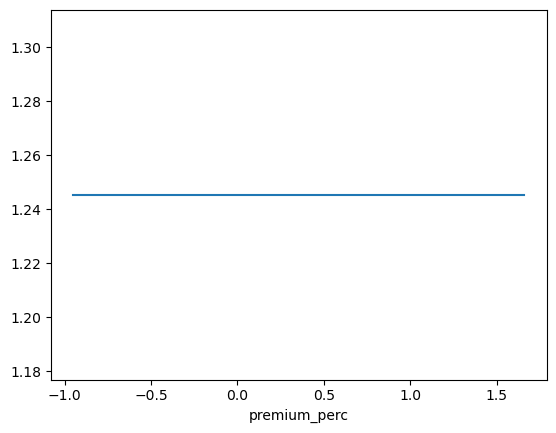

In [36]:
df_pred_results.groupby(['premium_perc'])['pred_itt_hour_log'].mean().plot()

In [ ]:
''' save prediction results '''
df_pred_results.reset_index(drop=True).to_feather("../model/model_prediction_241011_v1.ftr")

### load model and replicate

In [ ]:
loaded_effect_model = load_model("2_analysis/data/3_model/Deep IV/241009 v2/DeepIV_batch1000prods_100epochs (_effect_model).h5")

In [ ]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.00001), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [ ]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

''' fit Deep IV by 50 products batch '''
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

In [ ]:
model_test._effect_model = loaded_effect_model

In [ ]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, model_test.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

In [ ]:
display(df_pred_results.head())
display(df_pred_results.tail())

# 4. Deep IV (241014 v2)
- optimizer: SGD (lr = 0.000001 following Tian et al. JMR(2024)
- batch size: 128

## prep data

In [12]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])
dict_most_sold_option = df_model.groupby(['product_id', 'option_rename'], as_index=False).size().sort_values(by=['product_id', 'size'], ascending=[True, False]).drop_duplicates(subset='product_id', keep='first').set_index('product_id')['option_rename'].to_dict()

In [13]:
''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'yyyymm', 'brand_likes_ln', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyymm'],  dtype=np.int8))

''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'brand', 'yyyymm', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'brand', 'yyyymm'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 271)


,product_id,itt_hour_ln,premium_perc,brand_likes_ln,msrp_dollar_ln,with_release_date,days_since_release_ln,likes_count_cumsum_1k,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199,category_1_accessory,category_1_bag,category_1_bottom,category_1_clock,category_1_outer,category_1_shoes,category_1_top,category_1_wallet,yyyymm_2020-01,yyyymm_2020-02,yyyymm_2020-03,yyyymm_2020-04,yyyymm_2020-05,yyyymm_2020-06,yyyymm_2020-07,yyyymm_2020-08,yyyymm_2020-09,yyyymm_2020-10,yyyymm_2020-11,yyyymm_2020-12,yyyymm_2021-01,yyyymm_2021-02,yyyymm_2021-03,yyyymm_2021-04,yyyymm_2021-05,yyyymm_2021-06,yyyymm_2021-07,yyyymm_2021-08,yyyymm_2021-09,yyyymm_2021-10,yyyymm_2021-11,yyyymm_2021-12,yyyymm_2022-01,yyyymm_2022-02,yyyymm_2022-03,yyyymm_2022-04,yyyymm_2022-05,yyyymm_2022-06,yyyymm_2022-07,yyyymm_2022-08,yyyymm_2022-09,yyyymm_2022-10,yyyymm_2022-11,yyyymm_2022-12,yyyymm_2023-01,yyyymm_2023-02,yyyymm_2023-03,yyyymm_2023-04,yyyymm_2023-05,yyyymm_2023-06,yyyymm_2023-07,yyyymm_2023-08,yyyymm_2023-09,yyyymm_2023-10,yyyymm_2023-11,yyyymm_2023-12,yyyymm_2024-01,yyyymm_2024-02,yyyymm_2024-03,yyyymm_2024-04,yyyymm_2024-05,yyyymm_2024-06,yyyymm_2024-07
0,25785,0.213991,0.053254,9.522666,4.875197,1,6.787845,1.697,1.688273,0.887339,-0.117374,-1.385981,0.413938,0.074346,0.200774,-0.997213,1.285838,0.419133,0.216886,-0.674666,-1.693699,2.447318,0.190503,-0.317794,-1.100298,1.278041,1.140656,0.082711,-1.113478,0.620378,-1.195107,1.640626,-0.176389,-1.115997,-1.482354,0.571948,0.777121,-0.127269,-0.705201,-0.012049,1.502452,0.590448,-0.074854,-1.501808,-0.283437,-0.52912,1.164206,0.622821,-0.218422,-1.173577,-0.5901,0.322662,-0.56384,-1.21063,-0.961995,0.354674,0.465221,-0.833342,0.03486,0.64757,-2.613901,-2.080983,-1.249036,-0.700649,0.080216,-0.396736,-0.035392,-0.363768,1.632348,-1.29707,1.00084,0.442977,1.319736,0.019556,1.456341,-0.387869,1.09626,-1.884798,0.563031,0.505214,-1.118019,0.746385,1.050469,0.993317,-0.550332,0.419397,0.559618,-0.201889,-0.130324,-0.042313,-0.352182,0.800843,-0.255372,1.208464,0.766441,0.059275,0.400712,0.236393,-1.369643,-2.224218,-0.129256,0.269537,-0.329148,-0.440212,-1.705625,-2.103551,1.056439,-1.121573,0.861638,-2.534518,0.260298,-1.071208,0.90235,0.827234,1.728115,0.157538,0.080846,-1.541854,2.551283,1.143483,0.424341,0.135952,0.255713,-0.465253,0.660505,-1.862788,-1.293297,0.253065,-0.812383,1.844097,-0.211633,-1.126535,0.908782,-0.597001,0.202109,0.854135,-1.318101,0.545495,-0.000616,-0.795328,1.656884,-0.100252,-0.365282,2.277506,0.326605,-0.532033,-0.59638,1.634852,0.315725,1.923016,-0.168743,0.054323,-1.240679,-0.252857,1.659186,-2.041288,-0.543616,-1.831248,0.811467,-2.248698,0.024175,1.43388,1.154518,-0.845681,1.035224,1.263258,0.81222,1.491068,0.748506,1.28151,0.383016,-0.25185,-1.041592,0.340245,-

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [16]:
x.shape

In [20]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.0000005), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-14 07:44:20.405260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 07:44:20.408348: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-14 07:44:37.405972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
101517/101517 [==============================] - 324s 3ms/step - loss: nan - val_loss: nan
Epoch 2/100
101517/101517 [==============================] - 324s 3ms/step - loss: nan - val_loss: nan
Epoch 1/100
101517/101517 [==============================] - 599s 6ms/step - loss: 3.6311 - val_loss: 4.0173
Epoch 2/100
101517/101517 [==============================] - 597s 6ms/step - loss: 3.3734 - val_loss: 3.7725
Epoch 3/100
101517/101517 [==============================] - 584s 6ms/step - loss: 3.1630 - val_loss: 3.5715
Epoch 4/100
101517/101517 [==============================] - 591s 6ms/step - loss: 2.9913 - val_loss: 3.4065
Epoch 5/100
101517/101517 [==============================] - 590s 6ms/step - loss: 2.8512 - val_loss: 3.2710
Epoch 6/100
101517/101517 [==============================] - 594s 6ms/step - loss: 2.7368 - val_loss: 3.1596
Epoch 7/100
101517/101517 [==============================] - 592s 6ms/step - loss: 2.6434 - val_loss: 3.0679
Epoch 8/100
101517/101517 [====

In [ ]:
loss: 2.2286 val_loss: 2.6243

In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [20]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241014_v2.h5")

## predict by product

In [29]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyymm = [col for col in df_model_org.columns if 'yyyymm_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyymm] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' update option as most sold option '''
for prod in tqdm(df_product_temp.index):
    most_sold_option = dict_most_sold_option[prod]
    df_product_temp.loc[prod ,'option_rename_{}'.format(most_sold_option)] = 1

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]
df_product_temp = df_product_temp.drop(columns=['brand', 'category_1', 'yyyymm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0

df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [30]:
df_product_temp.head()

,msrp_dollar_ln,with_release_date,days_since_release_ln,brand_likes_ln,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199,category_1_accessory,category_1_bag,category_1_bottom,category_1_clock,category_1_outer,category_1_shoes,category_1_top,category_1_wallet,yyyymm_2020-01,yyyymm_2020-02,yyyymm_2020-03,yyyymm_2020-04,yyyymm_2020-05,yyyymm_2020-06,yyyymm_2020-07,yyyymm_2020-08,yyyymm_2020-09,yyyymm_2020-10,yyyymm_2020-11,yyyymm_2020-12,yyyymm_2021-01,yyyymm_2021-02,yyyymm_2021-03,yyyymm_2021-04,yyyymm_2021-05,yyyymm_2021-06,yyyymm_2021-07,yyyymm_2021-08,yyyymm_2021-09,yyyymm_2021-10,yyyymm_2021-11,yyyymm_2021-12,yyyymm_2022-01,yyyymm_2022-02,yyyymm_2022-03,yyyymm_2022-04,yyyymm_2022-05,yyyymm_2022-06,yyyymm_2022-07,yyyymm_2022-08,yyyymm_2022-09,yyyymm_2022-10,yyyymm_2022-11,yyyymm_2022-12,yyyymm_2023-01,yyyymm_2023-02,yyyymm_2023-03,yyyymm_2023-04,yyyymm_2023-05,yyyymm_2023-06,yyyymm_2023-07,yyyymm_2023-08,yyyymm_2023-09,yyyymm_2023-10,yyyymm_2023-11,yyyymm_2023-12,yyyymm_2024-01,yyyymm_2024-02,yyyymm_2024-03,yyyymm_2024-04,yyyymm_2024-05,yyyymm_2024-06,yyyymm_2024-07
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25786,4.875197,1,0,10.200922,0.676309,-1.575297,-0.043607,0.873860,1.298814,-0.955692,-2.439239,-1.271508,-1.820027,-1.109349,1.496022,0.322924,1.464733,0.447997,-0.786919,0.211732,0.913748,0.543296,-0.584219,1.017928,1.558922,1.311388,-0.736336,1.201367,0.970808,-0.116500,0.048287,0.335001,0.218430,0.902921,-1.829400,-0.426615,-0.208741,1.003136,0.905561,0.559745,1.055308,0.892231,-0.448187,-1.287703,-0.169677,-0.084910,0.038936,-0.956525,-1.134178,-1.403784,1.282852,-1.874893,-1.041616,0.146413,-0.684310,1.476519,0.435089,0.597927,-0.187461,2.240213,1.601348,1.074337,1.998153,-0.074582,0.704644,-0.212487,-0.522875,-1.968355,0.337427,-0.625748,-0.413088,0.850287,-0.132112,0.404127,-0.471679,0.204815,-0.613978,0.480233,-2.298598,0.956519,0.576497,0.542541,0.226277,-0.164600,0.128972,0.687859,-2.463862,-0.939484,0.635167,-0.207418,0.766555,1.284232,-0.385585,-0.879169,-0.889584,-1.246138,-0.256314,0.161570,0.618637,-1.142575,-0.604334,-0.372020,-0.946612,0.668580,-3.220169,-0.569662,1.498479,0.401612,1.632720,1.737900,0.543994,1.129809,-0.660277,0.655443,-0.393510,-0.238439,2.872297,-0.577017,-0.173957,0.501610,0.422735,-0.746803,0.245213,-0.480137,1.588544,0.722840,0.831171,-0.672887,-0.687369,-0.572958,0.753926,-0.630964,-0.202878,-1.025298,0.835674,0.931618,-0.584492,-1.355118,-0.408156,-1.470205,-0.797451,-0.376605,-1.221284,0.370878,-0.125117,-0.527018,-0.417079,0.223910,

In [ ]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium_perc', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

In [39]:
df_pred_results = pd.concat(dict_results.values())

In [40]:
display(df_pred_results.head())
display(df_pred_results.tail())

,premium_perc,pred_itt_hour_log,product_id
0,-0.95,1.24535,25786
1,-0.94,1.24535,25786
2,-0.93,1.24535,25786
3,-0.92,1.24535,25786
4,-0.91,1.24535,25786


,premium_perc,pred_itt_hour_log,product_id
257,1.62,1.24535,134285
258,1.63,1.24535,134285
259,1.64,1.24535,134285
260,1.65,1.24535,134285
261,1.66,1.24535,134285


# 5. Deep IV (241014 v3)
- learning rate: 0.000001
- deepen the model layers and introduce batch normalization
- add gradient clipping

## prep data

In [12]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])
dict_most_sold_option = df_model.groupby(['product_id', 'option_rename'], as_index=False).size().sort_values(by=['product_id', 'size'], ascending=[True, False]).drop_duplicates(subset='product_id', keep='first').set_index('product_id')['option_rename'].to_dict()

In [13]:
''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'yyyymm', 'brand', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyymm', 'brand'],  dtype=np.int8))

''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'brand', 'yyyymm', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'brand', 'yyyymm'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 271)


,product_id,itt_hour_ln,premium_perc,brand_likes_ln,msrp_dollar_ln,with_release_date,days_since_release_ln,likes_count_cumsum_1k,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199,category_1_accessory,category_1_bag,category_1_bottom,category_1_clock,category_1_outer,category_1_shoes,category_1_top,category_1_wallet,yyyymm_2020-01,yyyymm_2020-02,yyyymm_2020-03,yyyymm_2020-04,yyyymm_2020-05,yyyymm_2020-06,yyyymm_2020-07,yyyymm_2020-08,yyyymm_2020-09,yyyymm_2020-10,yyyymm_2020-11,yyyymm_2020-12,yyyymm_2021-01,yyyymm_2021-02,yyyymm_2021-03,yyyymm_2021-04,yyyymm_2021-05,yyyymm_2021-06,yyyymm_2021-07,yyyymm_2021-08,yyyymm_2021-09,yyyymm_2021-10,yyyymm_2021-11,yyyymm_2021-12,yyyymm_2022-01,yyyymm_2022-02,yyyymm_2022-03,yyyymm_2022-04,yyyymm_2022-05,yyyymm_2022-06,yyyymm_2022-07,yyyymm_2022-08,yyyymm_2022-09,yyyymm_2022-10,yyyymm_2022-11,yyyymm_2022-12,yyyymm_2023-01,yyyymm_2023-02,yyyymm_2023-03,yyyymm_2023-04,yyyymm_2023-05,yyyymm_2023-06,yyyymm_2023-07,yyyymm_2023-08,yyyymm_2023-09,yyyymm_2023-10,yyyymm_2023-11,yyyymm_2023-12,yyyymm_2024-01,yyyymm_2024-02,yyyymm_2024-03,yyyymm_2024-04,yyyymm_2024-05,yyyymm_2024-06,yyyymm_2024-07
0,25785,0.213991,0.053254,9.522666,4.875197,1,6.787845,1.697,1.688273,0.887339,-0.117374,-1.385981,0.413938,0.074346,0.200774,-0.997213,1.285838,0.419133,0.216886,-0.674666,-1.693699,2.447318,0.190503,-0.317794,-1.100298,1.278041,1.140656,0.082711,-1.113478,0.620378,-1.195107,1.640626,-0.176389,-1.115997,-1.482354,0.571948,0.777121,-0.127269,-0.705201,-0.012049,1.502452,0.590448,-0.074854,-1.501808,-0.283437,-0.52912,1.164206,0.622821,-0.218422,-1.173577,-0.5901,0.322662,-0.56384,-1.21063,-0.961995,0.354674,0.465221,-0.833342,0.03486,0.64757,-2.613901,-2.080983,-1.249036,-0.700649,0.080216,-0.396736,-0.035392,-0.363768,1.632348,-1.29707,1.00084,0.442977,1.319736,0.019556,1.456341,-0.387869,1.09626,-1.884798,0.563031,0.505214,-1.118019,0.746385,1.050469,0.993317,-0.550332,0.419397,0.559618,-0.201889,-0.130324,-0.042313,-0.352182,0.800843,-0.255372,1.208464,0.766441,0.059275,0.400712,0.236393,-1.369643,-2.224218,-0.129256,0.269537,-0.329148,-0.440212,-1.705625,-2.103551,1.056439,-1.121573,0.861638,-2.534518,0.260298,-1.071208,0.90235,0.827234,1.728115,0.157538,0.080846,-1.541854,2.551283,1.143483,0.424341,0.135952,0.255713,-0.465253,0.660505,-1.862788,-1.293297,0.253065,-0.812383,1.844097,-0.211633,-1.126535,0.908782,-0.597001,0.202109,0.854135,-1.318101,0.545495,-0.000616,-0.795328,1.656884,-0.100252,-0.365282,2.277506,0.326605,-0.532033,-0.59638,1.634852,0.315725,1.923016,-0.168743,0.054323,-1.240679,-0.252857,1.659186,-2.041288,-0.543616,-1.831248,0.811467,-2.248698,0.024175,1.43388,1.154518,-0.845681,1.035224,1.263258,0.81222,1.491068,0.748506,1.28151,0.383016,-0.25185,-1.041592,0.340245,-

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [16]:
x.shape

In [20]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1)
                                ])


keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-14 07:44:20.405260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 07:44:20.408348: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-14 07:44:37.405972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
101517/101517 [==============================] - 324s 3ms/step - loss: nan - val_loss: nan
Epoch 2/100
 99030/101517 [============================>.] - ETA: 7s - loss: nan

In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [20]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241014_v3.h5")

## predict by product

In [29]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyymm = [col for col in df_model_org.columns if 'yyyymm_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyymm] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' update option as most sold option '''
for prod in tqdm(df_product_temp.index):
    most_sold_option = dict_most_sold_option[prod]
    df_product_temp.loc[prod ,'option_rename_{}'.format(most_sold_option)] = 1

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]
df_product_temp = df_product_temp.drop(columns=['brand', 'category_1', 'yyyymm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0

df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [30]:
df_product_temp.head()

,msrp_dollar_ln,with_release_date,days_since_release_ln,brand_likes_ln,VAE0,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,VAE10,VAE11,VAE12,VAE13,VAE14,VAE15,VAE16,VAE17,VAE18,VAE19,VAE20,VAE21,VAE22,VAE23,VAE24,VAE25,VAE26,VAE27,VAE28,VAE29,VAE30,VAE31,VAE32,VAE33,VAE34,VAE35,VAE36,VAE37,VAE38,VAE39,VAE40,VAE41,VAE42,VAE43,VAE44,VAE45,VAE46,VAE47,VAE48,VAE49,VAE50,VAE51,VAE52,VAE53,VAE54,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64,VAE65,VAE66,VAE67,VAE68,VAE69,VAE70,VAE71,VAE72,VAE73,VAE74,VAE75,VAE76,VAE77,VAE78,VAE79,VAE80,VAE81,VAE82,VAE83,VAE84,VAE85,VAE86,VAE87,VAE88,VAE89,VAE90,VAE91,VAE92,VAE93,VAE94,VAE95,VAE96,VAE97,VAE98,VAE99,VAE100,VAE101,VAE102,VAE103,VAE104,VAE105,VAE106,VAE107,VAE108,VAE109,VAE110,VAE111,VAE112,VAE113,VAE114,VAE115,VAE116,VAE117,VAE118,VAE119,VAE120,VAE121,VAE122,VAE123,VAE124,VAE125,VAE126,VAE127,VAE128,VAE129,VAE130,VAE131,VAE132,VAE133,VAE134,VAE135,VAE136,VAE137,VAE138,VAE139,VAE140,VAE141,VAE142,VAE143,VAE144,VAE145,VAE146,VAE147,VAE148,VAE149,VAE150,VAE151,VAE152,VAE153,VAE154,VAE155,VAE156,VAE157,VAE158,VAE159,VAE160,VAE161,VAE162,VAE163,VAE164,VAE165,VAE166,VAE167,VAE168,VAE169,VAE170,VAE171,VAE172,VAE173,VAE174,VAE175,VAE176,VAE177,VAE178,VAE179,VAE180,VAE181,VAE182,VAE183,VAE184,VAE185,VAE186,VAE187,VAE188,VAE189,VAE190,VAE191,VAE192,VAE193,VAE194,VAE195,VAE196,VAE197,VAE198,VAE199,category_1_accessory,category_1_bag,category_1_bottom,category_1_clock,category_1_outer,category_1_shoes,category_1_top,category_1_wallet,yyyymm_2020-01,yyyymm_2020-02,yyyymm_2020-03,yyyymm_2020-04,yyyymm_2020-05,yyyymm_2020-06,yyyymm_2020-07,yyyymm_2020-08,yyyymm_2020-09,yyyymm_2020-10,yyyymm_2020-11,yyyymm_2020-12,yyyymm_2021-01,yyyymm_2021-02,yyyymm_2021-03,yyyymm_2021-04,yyyymm_2021-05,yyyymm_2021-06,yyyymm_2021-07,yyyymm_2021-08,yyyymm_2021-09,yyyymm_2021-10,yyyymm_2021-11,yyyymm_2021-12,yyyymm_2022-01,yyyymm_2022-02,yyyymm_2022-03,yyyymm_2022-04,yyyymm_2022-05,yyyymm_2022-06,yyyymm_2022-07,yyyymm_2022-08,yyyymm_2022-09,yyyymm_2022-10,yyyymm_2022-11,yyyymm_2022-12,yyyymm_2023-01,yyyymm_2023-02,yyyymm_2023-03,yyyymm_2023-04,yyyymm_2023-05,yyyymm_2023-06,yyyymm_2023-07,yyyymm_2023-08,yyyymm_2023-09,yyyymm_2023-10,yyyymm_2023-11,yyyymm_2023-12,yyyymm_2024-01,yyyymm_2024-02,yyyymm_2024-03,yyyymm_2024-04,yyyymm_2024-05,yyyymm_2024-06,yyyymm_2024-07
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25786,4.875197,1,0,10.200922,0.676309,-1.575297,-0.043607,0.873860,1.298814,-0.955692,-2.439239,-1.271508,-1.820027,-1.109349,1.496022,0.322924,1.464733,0.447997,-0.786919,0.211732,0.913748,0.543296,-0.584219,1.017928,1.558922,1.311388,-0.736336,1.201367,0.970808,-0.116500,0.048287,0.335001,0.218430,0.902921,-1.829400,-0.426615,-0.208741,1.003136,0.905561,0.559745,1.055308,0.892231,-0.448187,-1.287703,-0.169677,-0.084910,0.038936,-0.956525,-1.134178,-1.403784,1.282852,-1.874893,-1.041616,0.146413,-0.684310,1.476519,0.435089,0.597927,-0.187461,2.240213,1.601348,1.074337,1.998153,-0.074582,0.704644,-0.212487,-0.522875,-1.968355,0.337427,-0.625748,-0.413088,0.850287,-0.132112,0.404127,-0.471679,0.204815,-0.613978,0.480233,-2.298598,0.956519,0.576497,0.542541,0.226277,-0.164600,0.128972,0.687859,-2.463862,-0.939484,0.635167,-0.207418,0.766555,1.284232,-0.385585,-0.879169,-0.889584,-1.246138,-0.256314,0.161570,0.618637,-1.142575,-0.604334,-0.372020,-0.946612,0.668580,-3.220169,-0.569662,1.498479,0.401612,1.632720,1.737900,0.543994,1.129809,-0.660277,0.655443,-0.393510,-0.238439,2.872297,-0.577017,-0.173957,0.501610,0.422735,-0.746803,0.245213,-0.480137,1.588544,0.722840,0.831171,-0.672887,-0.687369,-0.572958,0.753926,-0.630964,-0.202878,-1.025298,0.835674,0.931618,-0.584492,-1.355118,-0.408156,-1.470205,-0.797451,-0.376605,-1.221284,0.370878,-0.125117,-0.527018,-0.417079,0.223910,

In [43]:
df_product_temp.loc[prd].sum()

In [46]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium_perc', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/45691 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
df_pred_results = pd.concat(dict_results.values())

In [40]:
display(df_pred_results.head())
display(df_pred_results.tail())

,premium_perc,pred_itt_hour_log,product_id
0,-0.95,1.24535,25786
1,-0.94,1.24535,25786
2,-0.93,1.24535,25786
3,-0.92,1.24535,25786
4,-0.91,1.24535,25786


,premium_perc,pred_itt_hour_log,product_id
257,1.62,1.24535,134285
258,1.63,1.24535,134285
259,1.64,1.24535,134285
260,1.65,1.24535,134285
261,1.66,1.24535,134285
